In [2]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('C:/Users/elley/Desktop/Python/project_4_portfolio/mart_codeit/EDA2_finish.csv')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.head(3)

,ID,signup_ym,birth_year,annual_income,marital_status,children,recency,amount_alcohol,amount_fruit,amount_meat,amount_fish,amount_snack,amount_general,amount_total,num_purchase_web,num_purchase_store,num_purchase_discount,num_purchase_total,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,recency_grade,frequency_grade,monetary_grade,rfm_score,rfm_segment,age,age_group
0,5524,2020-12,1965,75579400.0,??,0,58,825500,114400,709800,223600,114400,114400,2102100,8,4,3,15,0,0,0,0,0,1,2,2,3,2.4,3,59,50대
1,2174,2022-06,1962,60247200.0,??,2,38,14300,1300,7800,2600,1300,7800,35100,1,2,2,5,0,0,0,0,0,0,2,1,1,1.2,1,62,60대
2,4141,2021-11,1973,93096900.0,??? ??,0,26,553800,63700,165100,144300,27300,54600,1008800,8,10,1,19,0,0,0,0,0,0,3,3,2,2.6,3,51,50대


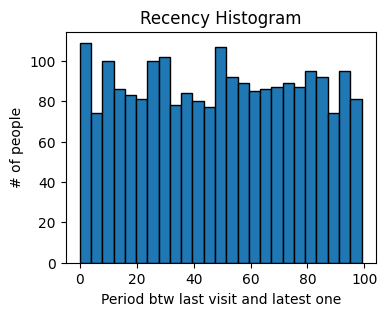

In [6]:
# RFM 세 지표의 분포를 확인하고 치우친 분포는 로그변환을 시켜서 정규분포와 비슷한 형태를 띄게 한다.
plt.figure(figsize=(4, 3))
plt.hist(df['recency'], bins = 25, edgecolor='black')
plt.title('Recency Histogram')
plt.xlabel('Period btw last visit and latest one')
plt.ylabel('# of people')
plt.show()

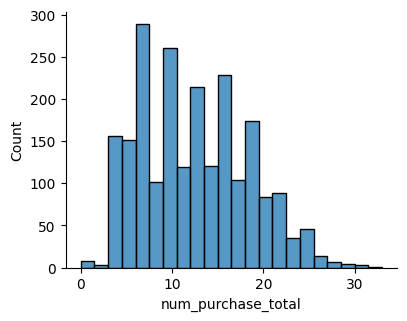

In [7]:
f=sns.displot(df['num_purchase_total'])
f.fig.set_size_inches(4, 3)
plt.show()

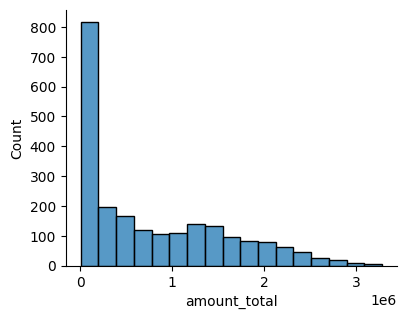

In [8]:
m=sns.displot(df['amount_total'])
m.fig.set_size_inches(4, 3)
plt.show()

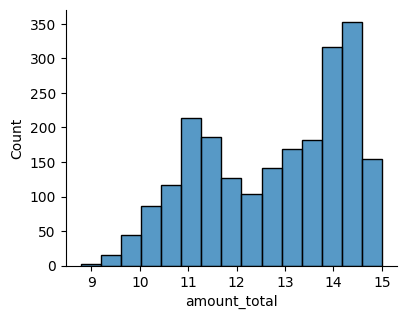

In [9]:
# Monetary는 로그변환을 통해 분포를 정규분포에 가깝게 만들어준다.
monetary_log = np.log(df['amount_total'])
m_1=sns.displot(monetary_log)
m_1.fig.set_size_inches(4, 3)
plt.show()

In [10]:
df['monetary_log'] = monetary_log

### Min-max scaling 한 후 clustering

In [11]:
# RFM에 필요한 컬럼들만 추출하여 따로 데이터프레임을 만든다.
rfm = df[['recency', 'num_purchase_total', 'monetary_log']]

In [12]:
# 최소값이 0, 최대값이 1인 MinMaxScaler 사용
scaler = MinMaxScaler()

In [13]:
# Fit and transform the data (train data와 test data를 따로 지정하지 않았음)
scaled_data = scaler.fit_transform(rfm)

In [14]:
# Convert the scaled data back into a DataFrame (optional)
scaled_rfm = pd.DataFrame(scaled_data, columns=rfm.columns)

In [15]:
scaled_rfm.describe()

,recency,num_purchase_total,monetary_log
count,2213.000000,2213.000000,2213.000000
mean,0.495027,0.370250,0.643293
std,0.292342,0.177581,0.238243
min,0.000000,0.000000,0.000000
25%,0.242424,0.212121,0.421663
50%,0.494949,0.363636,0.702781
75%,0.747475,0.515152,0.858728
max,1.000000,1.000000,1.000000


In [16]:
# recency 값 역전시키기
inverted_recency = 1 - scaled_rfm['recency']

In [17]:
scaled_rfm['inverted_recency'] = inverted_recency

In [18]:
scaled_rfm.head(3)

,recency,num_purchase_total,monetary_log,inverted_recency
0,0.585859,0.454545,0.928402,0.414141
1,0.383838,0.151515,0.270927,0.616162
2,0.262626,0.575758,0.810453,0.737374


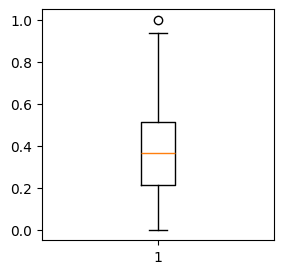

In [19]:
plt.figure(figsize=(3,3))
plt.boxplot(scaled_rfm['num_purchase_total'])
plt.show()

In [20]:
mod_scaled_rfm = scaled_rfm.drop('recency', axis=1)

In [21]:
from sklearn.cluster import KMeans 

In [22]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(mod_scaled_rfm)
    wcss.append(kmeans.inertia_)  # inertia는 WCSS 값

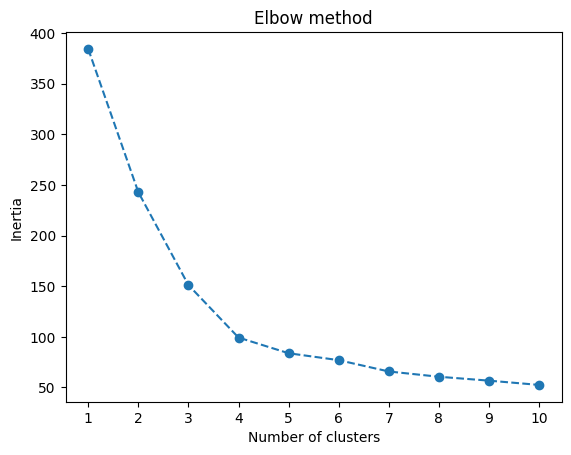

In [23]:
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.show()

#### 3-4 기울기와 4-5기울기에서 차이가 나므로 군집을 4개로 하면 적당할 것 같음.

In [24]:
# 모델 학습
clust_model = KMeans(n_clusters = 4, max_iter = 50, random_state = 42) # 클러스터 갯수
# 생성한 모델로 데이터를 학습시킴
clust_model.fit(mod_scaled_rfm) # unsupervised learning 

KMeans(max_iter=50, n_clusters=4, random_state=42)

In [25]:
cluster_labels= clust_model.labels_

In [26]:
rfm_new = mod_scaled_rfm.assign(Cluster = cluster_labels)

In [27]:
rfm_new.head(3)

,num_purchase_total,monetary_log,inverted_recency,Cluster
0,0.454545,0.928402,0.414141,2
1,0.151515,0.270927,0.616162,3
2,0.575758,0.810453,0.737374,0


### ** 각 RFM 등급의 분포를 관찰

In [28]:
rfm_new.rename(columns={'num_purchase_total': 'Frequency', 'monetary_log': 'Monetary', 
                               'inverted_recency':'Recency'}, inplace=True)
# mod = mod_scaled_rfm.reset_index(drop = True)
rfm_new.head(2)

,Frequency,Monetary,Recency,Cluster
0,0.454545,0.928402,0.414141,2
1,0.151515,0.270927,0.616162,3


In [29]:
from matplotlib import font_manager, rc
import platform

In [30]:
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')  

<Figure size 500x500 with 0 Axes>

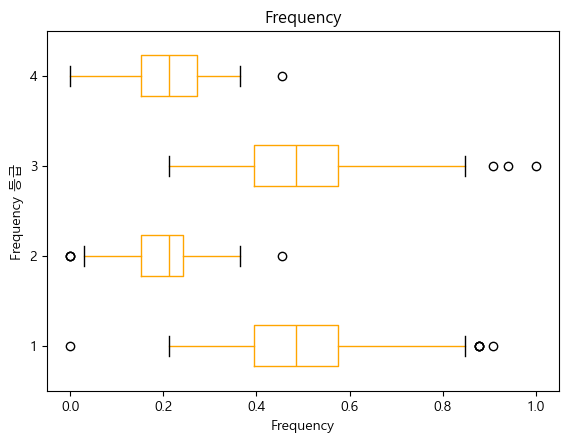

In [31]:
f = rfm_new[['Frequency', 'Cluster']]

# 캔버스 크기 조절
plt.figure(figsize=(5, 5))

# 박스 플롯 그리기
boxplot = f.boxplot(boxprops=dict(color='orange'), 
                    medianprops=dict(color='orange'),
                    whiskerprops=dict(color='orange'),
                    column='Frequency', by='Cluster', grid=False, vert=False)

# 제목 및 라벨 추가
plt.title('Frequency')
plt.xlabel('Frequency')
plt.ylabel('Frequency 등급')
plt.suptitle('') 
new_category_names = ['1', '2', '3', '4']
plt.gca().set_yticklabels(new_category_names)

#boxplot.set_yticklabels(new_category_names)

# 플롯 출력
plt.show()

<Figure size 800x600 with 0 Axes>

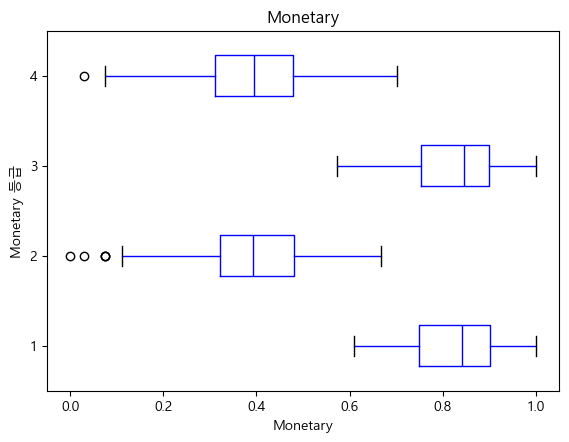

In [32]:
m = rfm_new[['Monetary', 'Cluster']]

# 캔버스 크기 조절
plt.figure(figsize=(8, 6))

# 박스 플롯 그리기
boxplot = m.boxplot(boxprops=dict(color='blue'), 
                    medianprops=dict(color='blue'),
                    whiskerprops=dict(color='blue'),
                    column='Monetary', by='Cluster', grid=False, vert=False)

# 제목 및 라벨 추가
plt.title('Monetary')
plt.xlabel('Monetary')
plt.ylabel('Monetary 등급')
plt.suptitle('') 
new_category_names = ['1', '2', '3', '4']
plt.gca().set_yticklabels(new_category_names)

#boxplot.set_yticklabels(new_category_names)

# 플롯 출력
plt.show()

<Figure size 800x600 with 0 Axes>

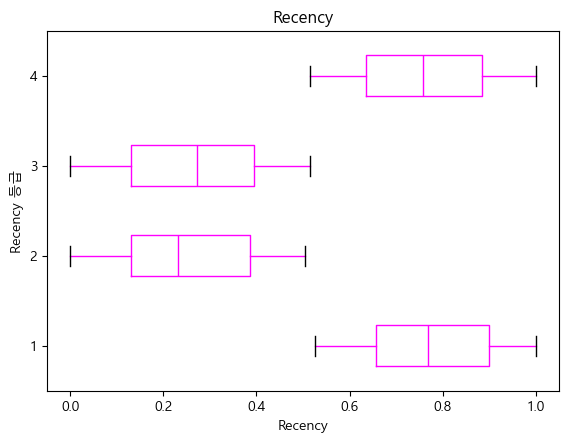

In [33]:
r = rfm_new[['Recency', 'Cluster']]

# 캔버스 크기 조절
plt.figure(figsize=(8, 6))

# 박스 플롯 그리기
boxplot = r.boxplot(boxprops=dict(color='magenta'), 
                    medianprops=dict(color='magenta'),
                    whiskerprops=dict(color='magenta'),
                    column='Recency', by='Cluster', grid=False, vert=False)

# 제목 및 라벨 추가
plt.title('Recency')
plt.xlabel('Recency')
plt.ylabel('Recency 등급')
plt.suptitle('') 
new_category_names = ['1', '2', '3', '4']
plt.gca().set_yticklabels(new_category_names)

plt.show()

In [34]:
rfm_n = rfm_new.set_index('Cluster')
rfm_n.head(3)

,Frequency,Monetary,Recency
Cluster,,,
2,0.454545,0.928402,0.414141
3,0.151515,0.270927,0.616162
0,0.575758,0.810453,0.737374


In [35]:
print(rfm_n.index.min())
print(rfm_n.index.max())

0
3


In [36]:
mean_values = rfm_n.groupby(rfm_n.index).mean()
mean_values

,Frequency,Monetary,Recency
Cluster,,,
0,0.494076,0.824391,0.771526
1,0.204675,0.395915,0.254101
2,0.486895,0.824062,0.267106
3,0.205314,0.392383,0.762419


In [42]:
new_index = {0: 'High', 1: 'Low', 2: 'Middle_High', 3: 'Middle_Low'}
mean_values.rename(index=new_index, inplace=True)

In [43]:
mean_values

,Frequency,Monetary,Recency
Cluster,,,
High,0.494076,0.824391,0.771526
Low,0.204675,0.395915,0.254101
Middle_High,0.486895,0.824062,0.267106
Middle_Low,0.205314,0.392383,0.762419


In [44]:
count = rfm_n.groupby(rfm_n.index).size()
count

Cluster
0    601
1    468
2    681
3    463
dtype: int64

In [45]:
new_index = ['High', 'Low', 'Middle_High', 'Middle_Low']
count.index = new_index

In [46]:
rfm_c= pd.concat([mean_values, count], axis=1)
rfm_c.rename(columns={0: '명수'}, inplace=True)

In [47]:
rfm_c

,Frequency,Monetary,Recency,명수
High,0.494076,0.824391,0.771526,601
Low,0.204675,0.395915,0.254101,468
Middle_High,0.486895,0.824062,0.267106,681
Middle_Low,0.205314,0.392383,0.762419,463


In [48]:
new_index = {0: 4, 1: 1, 2: 3, 3: 2}
rfm_n.rename(index=new_index, inplace=True)

In [49]:
rfm_n.head(3)

,Frequency,Monetary,Recency
Cluster,,,
3,0.454545,0.928402,0.414141
2,0.151515,0.270927,0.616162
4,0.575758,0.810453,0.737374


In [50]:
rfm_n = rfm_n.reset_index()

In [51]:
rfm_n.head(2)

,Cluster,Frequency,Monetary,Recency
0,3,0.454545,0.928402,0.414141
1,2,0.151515,0.270927,0.616162


In [52]:
col = rfm_n.pop('Cluster')
rfm_n.insert(3, 'Cluster', col)  

In [53]:
rfm_n.head(2)

,Frequency,Monetary,Recency,Cluster
0,0.454545,0.928402,0.414141,3
1,0.151515,0.270927,0.616162,2


In [54]:
dff = pd.concat([df, rfm_n], axis = 1)

In [55]:
df = dff

In [56]:
df.head(2)

,ID,signup_ym,birth_year,annual_income,marital_status,children,recency,amount_alcohol,amount_fruit,amount_meat,amount_fish,amount_snack,amount_general,amount_total,num_purchase_web,num_purchase_store,num_purchase_discount,num_purchase_total,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,recency_grade,frequency_grade,monetary_grade,rfm_score,rfm_segment,age,age_group,monetary_log,Frequency,Monetary,Recency,Cluster
0,5524,2020-12,1965,75579400.0,??,0,58,825500,114400,709800,223600,114400,114400,2102100,8,4,3,15,0,0,0,0,0,1,2,2,3,2.4,3,59,50대,14.558447,0.454545,0.928402,0.414141,3
1,2174,2022-06,1962,60247200.0,??,2,38,14300,1300,7800,2600,1300,7800,35100,1,2,2,5,0,0,0,0,0,0,2,1,1,1.2,1,62,60대,10.465956,0.151515,0.270927,0.616162,2


In [57]:
def category(x):
    total = df.groupby('Cluster').agg({df.columns[x]: 'sum'}).reset_index()
    return total

In [58]:
results = {}

for i in range(7, 13):  
    df_i = category(i)  
    results[f'df_{i}'] = df_i  
    
    if i > 7: 
        df_prev = results[f'df_{i-1}']  
        df_i = pd.concat([df_i, df_prev], axis=1, join='outer') 

    results[f'df_{i}'] = df_i

In [59]:
category = results['df_12']
cluster= category.iloc[:, 0]

In [60]:
amount = category.drop(columns=[category.columns[2], category.columns[4], category.columns[6], category.columns[8], category.columns[10]])

In [61]:
concat = pd.concat([cluster, amount], axis=1)
concat

,Cluster,amount_general,amount_snack,amount_fish,amount_meat,amount_fruit,amount_alcohol
0,1,8132800,2793700,3430700,11316500,2579200,18441800
1,2,8037900,2503800,3671200,10489700,2528500,18593900
2,3,58672900,39344500,53121900,240789900,36467600,449814300
3,4,51485200,33134400,48049300,217738300,34156200,391046500


In [62]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Malgun Gothic'

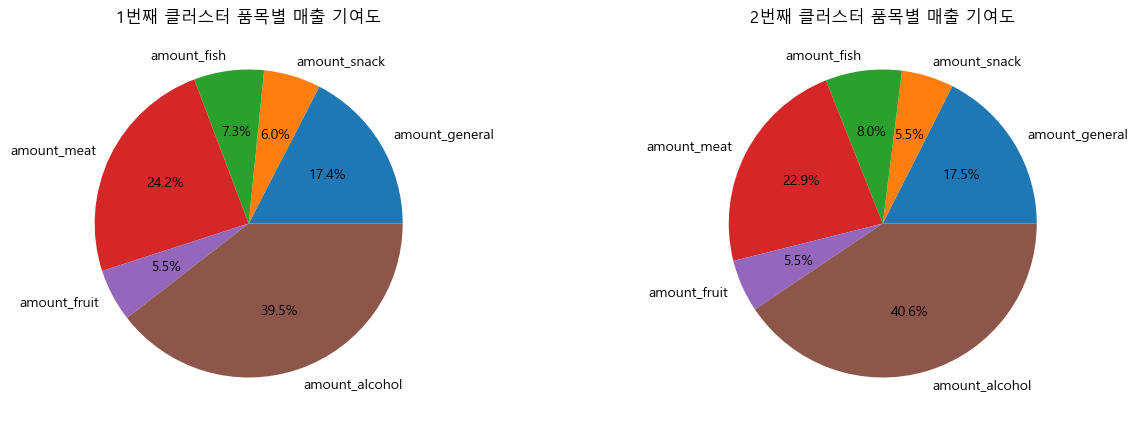

In [63]:
# 서브플롯 크기 조정 및 생성
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1행 3열의 서브플롯 생성

# 서브플롯의 레전드가 동일하므로 새로운 이미지로 레전드 표시
# fig, legend_ax = plt.subplots()

# 서브플롯
for i in range(1, 3):
    concat_i = pd.DataFrame(concat.iloc[i-1, 1:7])
    
    # 파이차트 그리기
    concat_i.plot(
        kind='pie',
        y=concat_i.columns[0],
        autopct='%.1f%%',
        # labels=[f'{x}' for x in ag],
        title=f'{i}번째 클러스터 품목별 매출 기여도',
        ylabel='',
        legend=False,
        ax = axes[i-1])

plt.show()

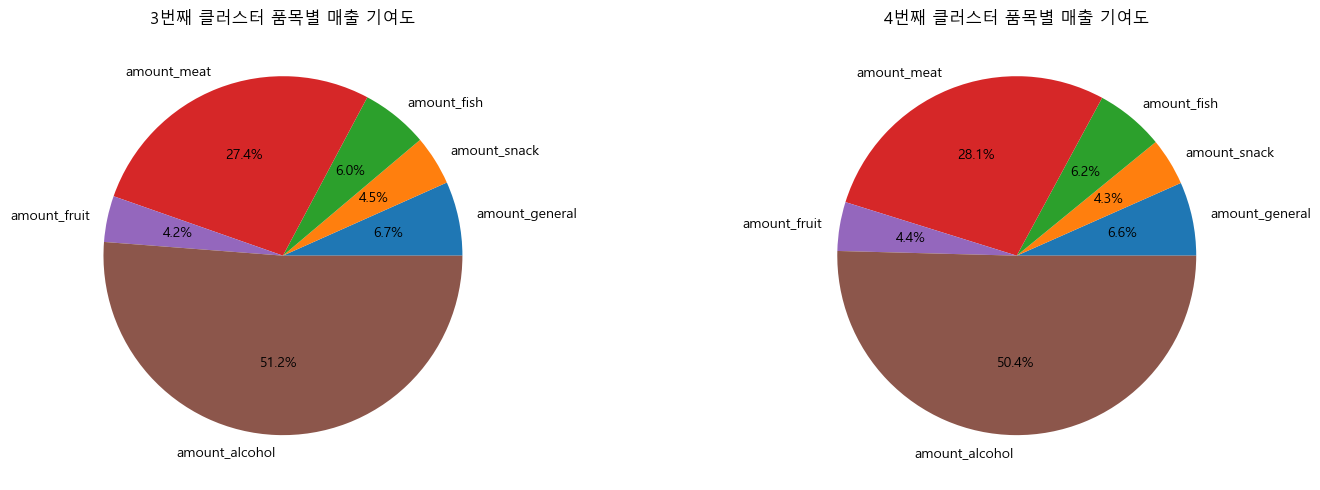

In [64]:
# 서브플롯 크기 조정 및 생성
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1행 2열의 서브플롯 생성

# 서브플롯
for idx, i in enumerate(range(3, 5)):
    concat_i = pd.DataFrame(concat.iloc[i-1, 1:7])
    
    # 파이차트 그리기
    concat_i.plot(
        kind='pie',
        y=concat_i.columns[0],    # concat_i의 첫 번째 컬럼 선택
        autopct='%.1f%%',
        title=f'{i}번째 클러스터 품목별 매출 기여도',
        ylabel='',
        legend=False,
        ax=axes[idx])  # axes 인덱스를 idx로 변경

plt.tight_layout()
plt.show()

In [65]:
## 프로모션 참여율
pro = df.groupby('Cluster')[['promotion_1', 'promotion_2', 'promotion_3', 'promotion_4', 'promotion_5', 'promotion_6']].sum()
pro

,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6
Cluster,,,,,,
1,0,0,24,6,0,16
2,0,2,39,2,0,65
3,68,15,46,86,82,91
4,74,13,54,70,79,161


In [66]:
print(df[df['Cluster'] == 1].shape)
print(df[df['Cluster'] == 2].shape)
print(df[df['Cluster'] == 3].shape)
print(df[df['Cluster'] == 4].shape)

(468, 36)
(463, 36)
(681, 36)
(601, 36)


In [67]:
pro_1 = pro.iloc[0, 0:]/468
pro_2 = pro.iloc[1, 0:]/463
pro_3 = pro.iloc[2, 0:]/681
pro_4 = pro.iloc[3, 0:]/601

In [68]:
prom = pd.concat([pro_1, pro_2, pro_3, pro_4], axis=1)
prom = prom.T
prom = prom.set_index(concat['Cluster'])
prom

,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6
Cluster,,,,,,
1,0.000000,0.000000,0.051282,0.012821,0.000000,0.034188
2,0.000000,0.004320,0.084233,0.004320,0.000000,0.140389
3,0.099853,0.022026,0.067548,0.126285,0.120411,0.133627
4,0.123128,0.021631,0.089850,0.116473,0.131448,0.267887


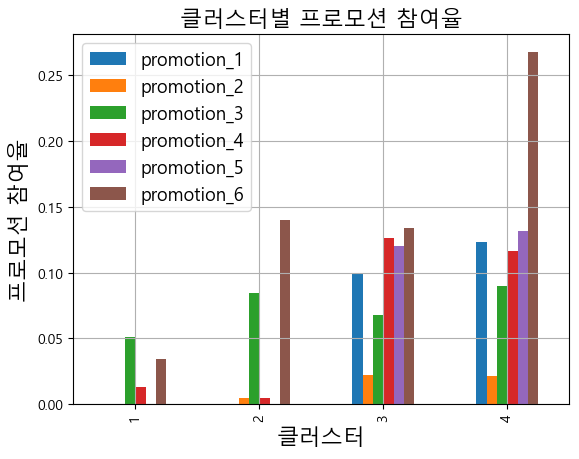

In [78]:
prom.plot(kind='bar')
plt.title('클러스터별 프로모션 참여율', fontsize = 16)
plt.xlabel('클러스터', fontsize=16)
plt.ylabel('프로모션 참여율', fontsize=16)
plt.legend(fontsize=13)
plt.grid()

In [211]:
cluster_age = df.groupby(['Cluster', 'age_group']).size()

In [214]:
ca = pd.DataFrame(cluster_age)

In [224]:
ca = ca.reset_index()

C:\Users\elley\AppData\Local\Temp\ipykernel_40832\246974563.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gen_i.plot(
C:\Users\elley\AppData\Local\Temp\ipykernel_40832\246974563.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gen_i.plot(
C:\Users\elley\AppData\Local\Temp\ipykernel_40832\246974563.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_dow

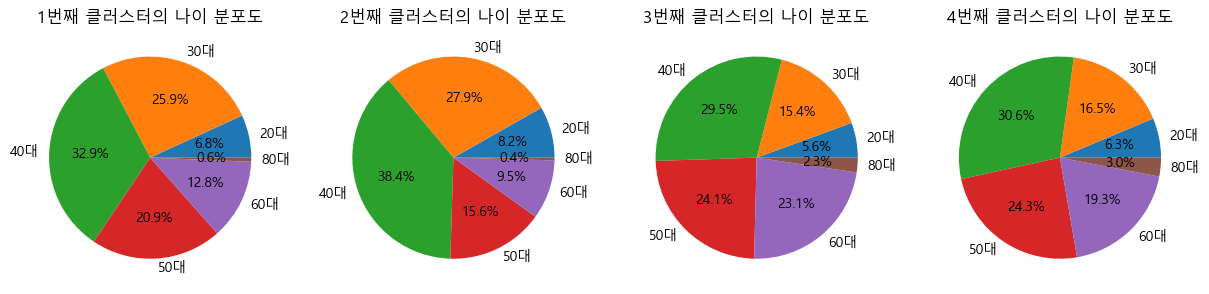

In [227]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
ag = ['20대', '30대', '40대', '50대', '60대', '80대']

for i in range(1,5):
    gen_i = ca[ca['Cluster']==i]
    gen_i = gen_i.T
    gen_i = gen_i.iloc[2,:]
    gen_i.plot(
    kind='pie',
    # y=gen_i.columns[0]
    title=f'{i}번째 클러스터의 나이 분포도',
    labels=[f'{x}' for x in ag],
    autopct='%.1f%%',
    ylabel='',
    ax = axes[i-1]
)

plt.show()

In [229]:
df = df.drop(columns=['marital_status'])

In [298]:
df.head(2)

,ID,signup_ym,birth_year,annual_income,children,recency,amount_alcohol,amount_fruit,amount_meat,amount_fish,amount_snack,amount_general,amount_total,num_purchase_web,num_purchase_store,num_purchase_discount,num_purchase_total,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,recency_grade,frequency_grade,monetary_grade,rfm_score,rfm_segment,age,age_group,monetary_log,Frequency,Monetary,Recency,Cluster
0,5524,2020-12,1965,75579400.0,0,58,825500,114400,709800,223600,114400,114400,2102100,8,4,3,15,0,0,0,0,0,1,2,2,3,2.4,3,59,50대,14.558447,0.454545,0.928402,0.414141,3
1,2174,2022-06,1962,60247200.0,2,38,14300,1300,7800,2600,1300,7800,35100,1,2,2,5,0,0,0,0,0,0,2,1,1,1.2,1,62,60대,10.465956,0.151515,0.270927,0.616162,2


In [230]:
data = pd.read_csv('C:/Users/elley/Desktop/Python/project_4_portfolio/mart_codeit/final_2.csv')

In [231]:
marriage = data['marital_st']

In [232]:
df.insert(loc=4, column='marital_st', value=marriage)

In [233]:
df.head(2)

,ID,signup_ym,birth_year,annual_income,marital_st,children,recency,amount_alcohol,amount_fruit,amount_meat,amount_fish,amount_snack,amount_general,amount_total,num_purchase_web,num_purchase_store,num_purchase_discount,num_purchase_total,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,recency_grade,frequency_grade,monetary_grade,rfm_score,rfm_segment,age,age_group,monetary_log,Frequency,Monetary,Recency,Cluster
0,5524,2020-12,1965,75579400.0,미혼,0,58,825500,114400,709800,223600,114400,114400,2102100,8,4,3,15,0,0,0,0,0,1,2,2,3,2.4,3,59,50대,14.558447,0.454545,0.928402,0.414141,3
1,2174,2022-06,1962,60247200.0,미혼,2,38,14300,1300,7800,2600,1300,7800,35100,1,2,2,5,0,0,0,0,0,0,2,1,1,1.2,1,62,60대,10.465956,0.151515,0.270927,0.616162,2


In [234]:
none = df['marital_st'].isna().any()
none

np.True_

In [235]:
none = df['children'].isna().any()
none

np.False_

In [236]:
ch = df.groupby(['Cluster','children']).size()
ch = pd.DataFrame(ch)
ch = ch.reset_index()
cha = ch.T.T

In [237]:
ch_01 = cha[cha['Cluster'] == 1]
#ch = ch_01.T
#ch.iloc[2,:]
ch_01.T

,0,1,2,3
Cluster,1,1,1,1
children,0,1,2,3
0,55,258,137,18


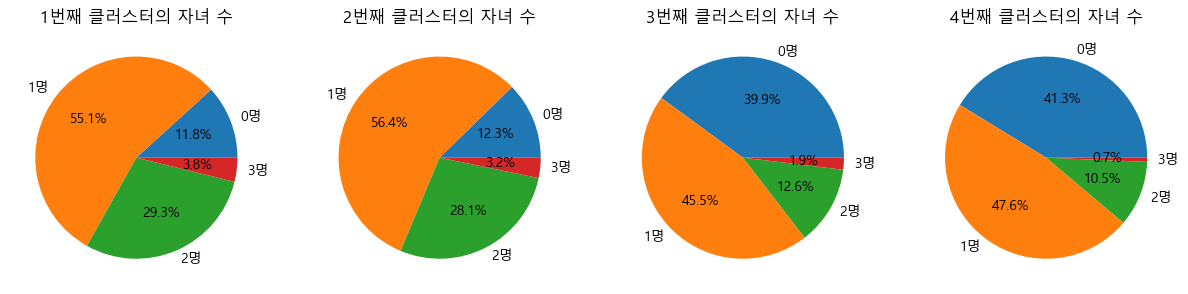

In [238]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 1행 3열의 서브플롯 생성
ag = ['0명', '1명', '2명', '3명']

# 서브플롯
for i in range(1, 5):
    ch_i = ch[ch['Cluster']==i]
    ch_i = ch_i.T
    ch_i = ch_i.iloc[2,:]
    
    # 파이차트 그리기
    ch_i.plot(
        kind='pie',
        # y=ch_i.columns[0],
        autopct='%.1f%%',
        labels=[f'{x}' for x in ag],
        title=f'{i}번째 클러스터의 자녀 수',
        ylabel='',
        legend=False,
        ax = axes[i-1])

plt.show()

In [330]:
df_m = df.dropna(subset=['marital_st'])
df_m.head(3)

,ID,signup_ym,birth_year,annual_income,marital_st,children,recency,amount_alcohol,amount_fruit,amount_meat,amount_fish,amount_snack,amount_general,amount_total,num_purchase_web,num_purchase_store,num_purchase_discount,num_purchase_total,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,recency_grade,frequency_grade,monetary_grade,rfm_score,rfm_segment,age,age_group,monetary_log,Frequency,Monetary,Recency,Cluster
0,5524,2020-12,1965,75579400.0,미혼,0,58,825500,114400,709800,223600,114400,114400,2102100,8,4,3,15,0,0,0,0,0,1,2,2,3,2.4,3,59,50대,14.558447,0.454545,0.928402,0.414141,3
1,2174,2022-06,1962,60247200.0,미혼,2,38,14300,1300,7800,2600,1300,7800,35100,1,2,2,5,0,0,0,0,0,0,2,1,1,1.2,1,62,60대,10.465956,0.151515,0.270927,0.616162,2
2,4141,2021-11,1973,93096900.0,배우자 있음,0,26,553800,63700,165100,144300,27300,54600,1008800,8,10,1,19,0,0,0,0,0,0,3,3,2,2.6,3,51,50대,13.824272,0.575758,0.810453,0.737374,4


In [241]:
m = df.groupby(['Cluster','marital_st']).size()
m = pd.DataFrame(m)
m = m.reset_index()
ma = m.T

C:\Users\elley\AppData\Local\Temp\ipykernel_40832\3441391991.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m_i.plot(
C:\Users\elley\AppData\Local\Temp\ipykernel_40832\3441391991.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m_i.plot(
C:\Users\elley\AppData\Local\Temp\ipykernel_40832\3441391991.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_d

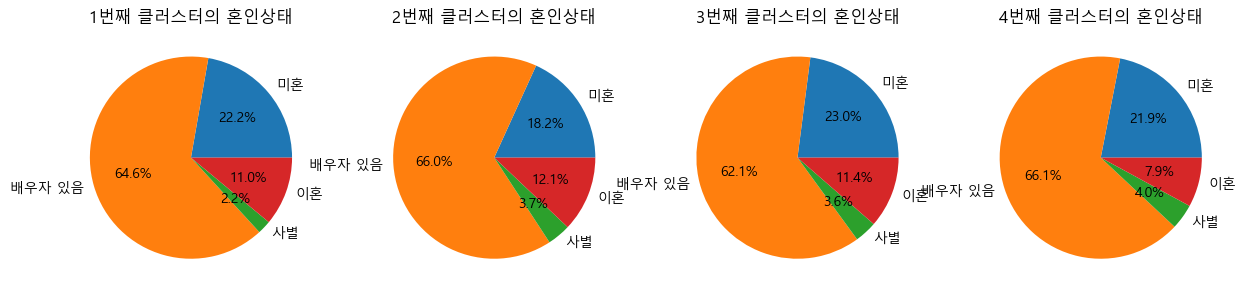

In [245]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 1행 3열의 서브플롯 생성
ag = ['미혼', '배우자 있음', '사별', '이혼']

# 서브플롯
for i in range(1, 5):
    m_i = m[m['Cluster']==i]
    m_i = m_i.T
    m_i = m_i.iloc[2,:]
    
    # 파이차트 그리기
    m_i.plot(
        kind='pie',
        # y=ch_i.columns[0],
        autopct='%.1f%%',
        labels=[f'{x}' for x in ag],
        title=f'{i}번째 클러스터의 혼인상태',
        ylabel='',
        legend=False,
        ax = axes[i-1])

plt.show()